<a href="https://colab.research.google.com/github/pillaisamarth/clg-proj/blob/main/Trend_and_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Libraries**

In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 791 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# **Setting Default plotting styles**

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

# **Fetching Stock prices using yfinance Library**

In this section we will get stock prices over four years for Google and Microsoft. However, for analysis, we will focus on Google stock prices for this entire program

In [ ]:
tech_list = [
    'GOOG',
    'MSFT'
]

end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)

for stocks in tech_list:
    globals()[stocks] = yf.download(stocks, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# **Function Definitions**

In This section, we will describe some functions later used in the program



In [ ]:
from sklearn.model_selection import train_test_split
def data_split(X, y, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
  return (X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score
def get_score(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)

In [ ]:
def detrend(X, y, model, label = None):
  y_cmp = y.copy()
  y_cmp[label] = pd.DataFrame(model.predict(X).reshape(-1), index = X.index)
  detrended_data = y - y_cmp
  return detrended_data  

def retrend(X, y, model, label = None):
  y_cmp = y.copy()
  y_cmp[label] = pd.DataFrame(model.predict(X).reshape(-1), index = X.index)
  retrended_data = y + y_cmp
  return retrended_data

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Creating DataFrame for Google Stock prices




In [ ]:
df = pd.DataFrame(GOOG[['Close']].copy())
df.head()

,Close
Date,
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500
2018-12-03,55.321499


In [ ]:
sd = df.copy()
sd.head()

,Close
Date,
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500
2018-12-03,55.321499


# Splitting Data

In this section, we will split the data into train, test and validation sets. The data from the beginning of the time series to 01-Jan-2022 belongs to train set, data from 01-Jan-2022 to 05-June-2022 belongs to validation set and data from 05-June-2022 to the end of the time series belongs to the test set.

In [ ]:
split_date_1 = '01-Jan-2022' #train to validate
split_date_2 = '05-June-2022' #validate to test
sd_train = sd.loc[sd.index <= split_date_1].copy()
sd_valid = sd.loc[(sd.index > split_date_1) & (sd.index < split_date_2)].copy()
sd_test = sd.loc[sd.index > split_date_2].copy()

Creating trend features

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess
# adding dummy features to learn trend
dp = DeterministicProcess(
    index = sd.index,
    constant = True,
    order = 4,
    drop = True
)

X = dp.in_sample()
X_d = X.copy()

print(X.head())

            const  trend  trend_squared  trend_cubed  trend**4
Date                                                          
2018-11-27    1.0    1.0            1.0          1.0       1.0
2018-11-28    1.0    2.0            4.0          8.0      16.0
2018-11-29    1.0    3.0            9.0         27.0      81.0
2018-11-30    1.0    4.0           16.0         64.0     256.0
2018-12-03    1.0    5.0           25.0        125.0     625.0


In [ ]:
import pickle
trend_model = pickle.load(open('Trend_model.sav', 'rb'))

In [ ]:
print('hello')

hello


In [ ]:
X.loc[sd_train.index, :]

,const,trend,trend_squared,trend_cubed,trend**4
Date,,,,,
2018-11-27,1.0,1.0,1.0,1.0,1.000000e+00
2018-11-28,1.0,2.0,4.0,8.0,1.600000e+01
2018-11-29,1.0,3.0,9.0,27.0,8.100000e+01
2018-11-30,1.0,4.0,16.0,64.0,2.560000e+02
2018-12-03,1.0,5.0,25.0,125.0,6.250000e+02
...,...,...,...,...,...
2021-12-27,1.0,776.0,602176.0,467288576.0,3.626159e+11
2021-12-28,1.0,777.0,603729.0,469097433.0,3.644887e+11
2021-12-29,1.0,778.0,605284.0,470910952.0,3.663687e+11


# Detrend Data

In [ ]:
detrended_train_data = detrend(X.loc[sd_train.index, :], sd_train, trend_model, 'Close')
detrended_validation_data = detrend(X.loc[sd_valid.index, :], sd_valid, trend_model, 'Close')
detrended_test_data = detrend(X.loc[sd_test.index, :], sd_test, trend_model, 'Close')

In [ ]:
detrended_train_data.head()

,Close
Date,
2018-11-27,6.382576
2018-11-28,8.203906
2018-11-29,8.040864
2018-11-30,8.083929
2018-12-03,8.423580


In [ ]:
detrended_validation_data.head()

,Close
Date,
2022-01-03,0.406428
2022-01-04,-0.253486
2022-01-05,-7.015405
2022-01-06,-7.113805
2022-01-07,-7.653141


In [ ]:
detrended_test_data.head()

,Close
Date,
2022-06-06,-6.843647
2022-06-07,-6.181574
2022-06-08,-5.724489
2022-06-09,-7.590364
2022-06-10,-10.621173


In [ ]:
X_train, y_train = create_features(detrended_train_data, label = 'Close')
X_valid, y_valid = create_features(detrended_validation_data, label = 'Close')
X_test, y_test = create_features(sd_test, label = 'Close')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


# Creating Gradient Boosting model

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000, objective = 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=50,
       verbose=False) 

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

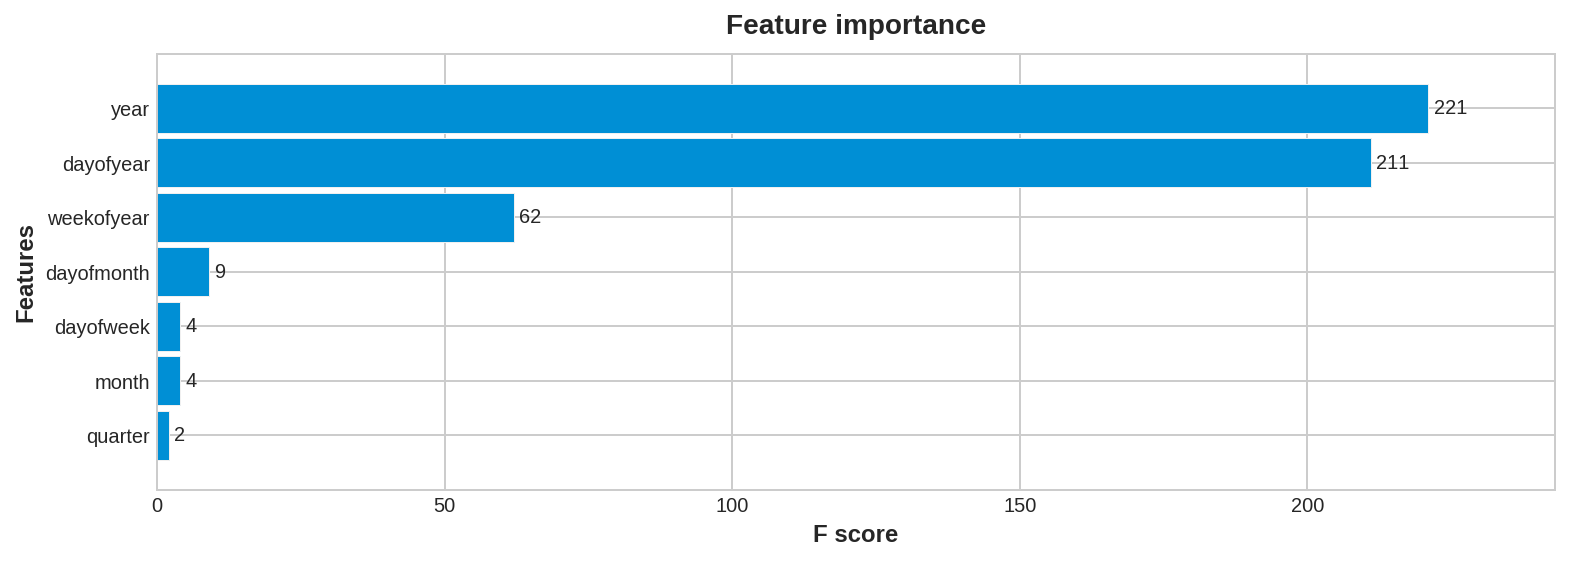

In [ ]:
_ = xgb.plot_importance(reg, height = 0.9)

In [ ]:
pred = sd_test.copy()
pred['Close'] = reg.predict(X_test)

In [ ]:
pred.head()

,Close
Date,
2022-06-06,1.293357
2022-06-07,1.293357
2022-06-08,1.293357
2022-06-09,1.293357
2022-06-10,1.293357


In [ ]:
detrended_test_data['predictions'] = retrend(X.loc[sd_test.index, :], pred, trend_model, 'Close')

In [ ]:
detrended_test_data.head()

,Close,predictions
Date,,
2022-06-06,-6.843647,125.147502
2022-06-07,-6.181574,124.704431
2022-06-08,-5.724489,124.255845
2022-06-09,-7.590364,123.801720
2022-06-10,-10.621173,123.342028


In [ ]:
mean_absolute_percentage_error(y_true = sd_test['Close'], y_pred = detrended_test_data['predictions'])

25.238361013157384

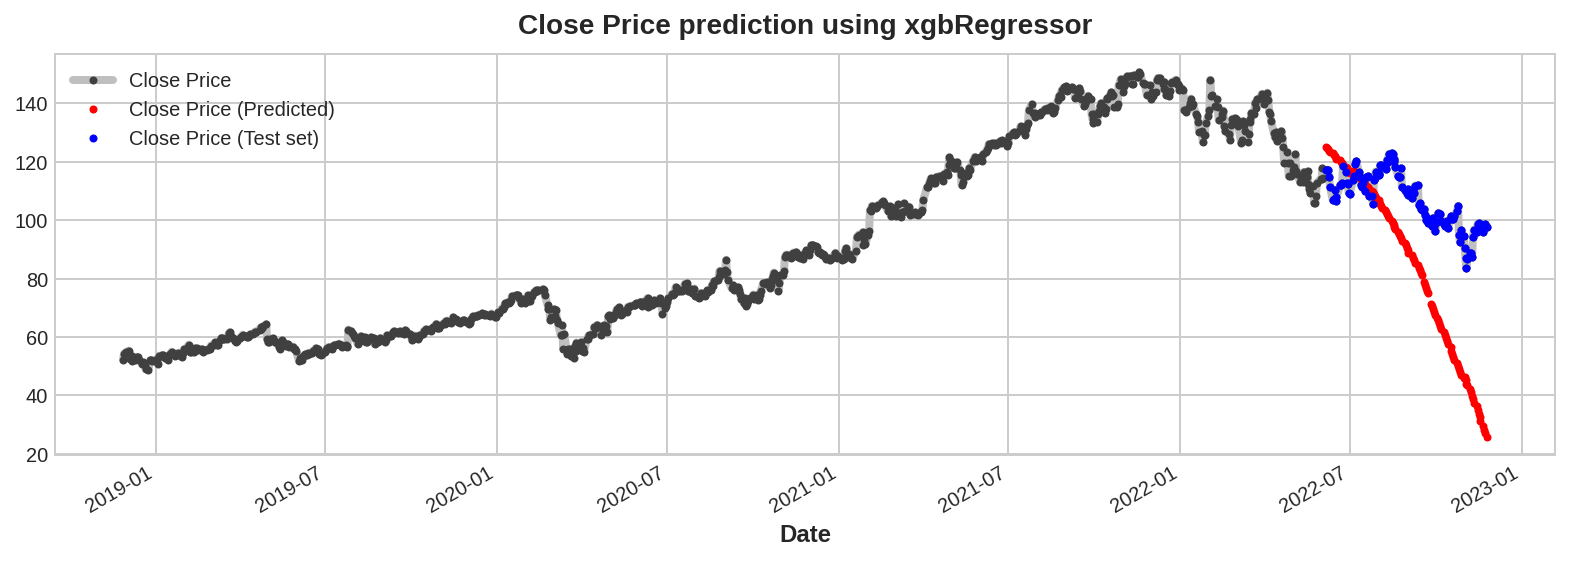

In [ ]:
ax = sd.plot(**plot_params)
ax = detrended_test_data['predictions'].plot(ax = ax, color = 'r', style = '.')
ax = y_test.plot(color = 'b', style = '.')
ax.set_title('Close Price prediction using xgbRegressor')
ax.legend(['Close Price', 'Close Price (Predicted)', 'Close Price (Test set)'])

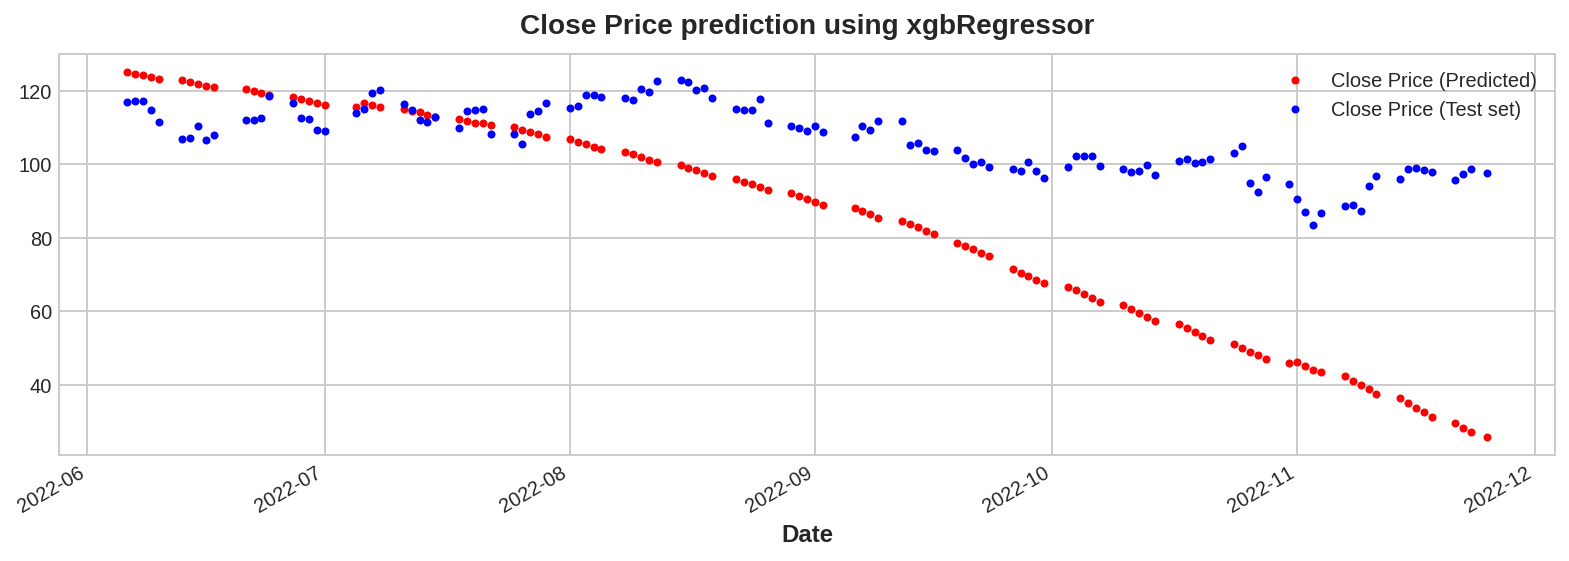

In [ ]:
ax = detrended_test_data['predictions'].plot(color = 'r', style = '.')
ax = y_test.plot(color = 'b', style = '.')
ax.set_title('Close Price prediction using xgbRegressor')
ax.legend(['Close Price (Predicted)', 'Close Price (Test set)'])